In [1]:
import os
import numpy as np
from niiutility import *

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Loading the Image and Label
* using (nibabel)[https://nipy.org/nibabel/nibabel_images.html]
* the data path is img_xx
* the label path is bv_bodyxx

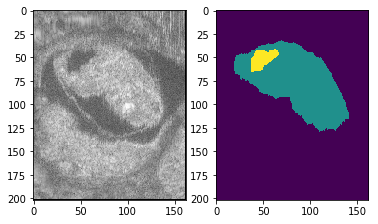

In [3]:
temp = loadnii(0)

fig, ax = plt.subplots(1,2)

slicing_index = 90

ax[0].imshow(temp[0][slicing_index], cmap='gray')
ax[1].imshow(temp[1][slicing_index])
plt.show()

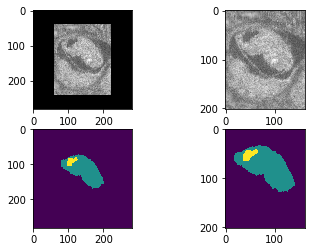

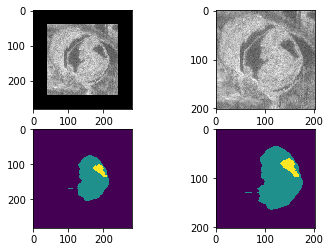

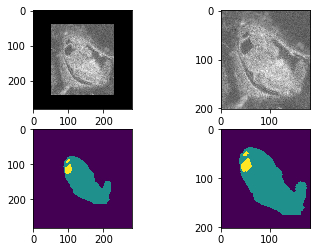

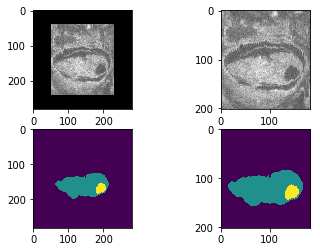

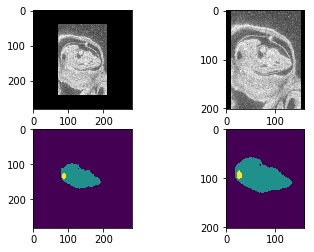

In [4]:
%reload_ext autoreload
image, label = loadallnii(5, 210, 282, 282, verbose=True)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import torchvision.datasets as dset
import torchvision.transforms as T

from classifiers import *

USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

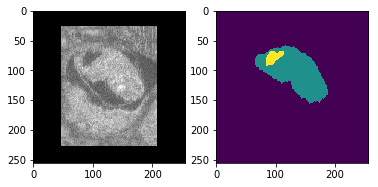

In [88]:
X, Y = loadnii(0)
X = zero_padding(X, 256, 256, 256)
Y = zero_padding(Y, 256, 256, 256)

show_image(X, Y)

X = X[::4,::4,::4]
Y = Y[::4,::4,::4]

X = (X - np.mean(X))/np.std(X)

X = X.reshape(1, 1, 64, 64, 64)
Y = Y.reshape(1, 64, 64, 64)

Xtr = torch.tensor(X)
Ytr = torch.tensor(Y)


In [89]:
def shape_test():
    x = torch.zeros((1, 1, 64, 64, 64), dtype=dtype)
    model = Dcon3D(64)
    scores = model(x)
    print(scores.size())

shape_test()

torch.Size([1, 3, 64, 64, 64])


In [67]:
def overfit_test(model, optimizer, x, y, epochs=1):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        
        if e%8 == 0:
            print('epoch %d, loss = %.4f' % (e, loss.item()))

In [68]:
learning_rate = 1e-3
model = Dcon3D(64)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print('first loss should be around ln3!')
overfit_test(model, optimizer, Xtr, Ytr, epochs=256)

first loss should be around ln3!
epoch 0, loss = 1.0199
epoch 8, loss = 0.9745
epoch 16, loss = 0.7870
epoch 24, loss = 0.3778
epoch 32, loss = 0.2736
epoch 40, loss = 0.2231
epoch 48, loss = 0.1948
epoch 56, loss = 0.1859
epoch 64, loss = 0.1732
epoch 72, loss = 0.1578
epoch 80, loss = 0.1416
epoch 88, loss = 0.1304
epoch 96, loss = 0.1223
epoch 104, loss = 0.1121
epoch 112, loss = 0.0958
epoch 120, loss = 0.0785
epoch 128, loss = 0.1587
epoch 136, loss = 0.0798
epoch 144, loss = 0.0723
epoch 152, loss = 0.0605
epoch 160, loss = 0.0507
epoch 168, loss = 0.0688
epoch 176, loss = 0.0691
epoch 184, loss = 0.0587
epoch 192, loss = 0.0553
epoch 200, loss = 0.0507
epoch 208, loss = 0.0447
epoch 216, loss = 0.0343
epoch 224, loss = 0.0430
epoch 232, loss = 0.0294
epoch 240, loss = 0.0294
epoch 248, loss = 0.0272


In [85]:
def overfit_show(model, x, y):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        
        scoresTorch = model(x)
        scores = scoresTorch.numpy()
        scores = scores.reshape(3, 64, 64, 64)
        label = y.numpy()
        label = label.reshape(64, 64, 64)
         
        class0map = scores[0]
        class1map = scores[1]
        class2map = scores[2]
        
        min0 = np.amin(class0map)
        max0= np.amax(class0map)
        
        min1 = np.amin(class1map)
        max1= np.amax(class1map)
        
        min2 = np.amin(class2map)
        max2= np.amax(class2map)
        
        class0map = (class0map - min0)/(max0-min0)
        class1map = (class1map - min1)/(max1-min1)
        class2map = (class2map - min2)/(max2-min2)
        
        fig, ax = plt.subplots(1,4)

        slicing_index = 32

        ax[0].imshow(class0map[slicing_index], cmap='gray')
        ax[1].imshow(class1map[slicing_index], cmap='gray')
        ax[2].imshow(class2map[slicing_index], cmap='gray')
        ax[3].imshow(label[slicing_index])
        
        plt.show()
        

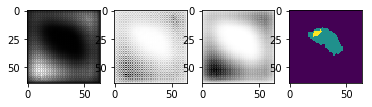

In [86]:
overfit_show(model, Xtr, Ytr)

In [14]:
from vnet import *

def shape_test(model):
    x = torch.zeros((1, 1, 32, 32, 32), dtype=dtype)
    scores = model(x)
    print(scores.size())

shape_vnet = VNet(3)
shape_test(shape_vnet)

torch.Size([1, 3, 32, 32, 32])
torch.Size([49152, 2])
